In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


In [2]:
# load local model file and initialize model class
from model import ModelClass
model = ModelClass() # set a few number of periods.


par = model.par
sol = model.sol
sim = model.sim

f:\MPC\Studenter\Speciale\Peter og Mathias\Code Peter\Design_retirement\model.py:69: SyntaxWarning: invalid escape sequence '\o'
  df = pd.read_csv('Data\overlevelses_ssh.csv')


In [3]:
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve()

We are in t = 69
We are in t = 68
We are in t = 67
We are in t = 66
We are in t = 65
We are in t = 64
We are in t = 63
We are in t = 62
We are in t = 61
We are in t = 60
We are in t = 59
We are in t = 58
We are in t = 57
We are in t = 56
We are in t = 55
We are in t = 54
We are in t = 53
We are in t = 52
We are in t = 51
We are in t = 50
We are in t = 49
We are in t = 48
We are in t = 47
We are in t = 46
We are in t = 45
We are in t = 44
We are in t = 43
We are in t = 42
We are in t = 41
We are in t = 40
We are in t = 39
We are in t = 38
We are in t = 37
We are in t = 36
We are in t = 35
We are in t = 34
We are in t = 33
We are in t = 32
We are in t = 31
We are in t = 30
We are in t = 29
We are in t = 28
We are in t = 27
We are in t = 26
We are in t = 25
We are in t = 24
We are in t = 23
We are in t = 22
We are in t = 21
We are in t = 20
We are in t = 19
We are in t = 18
We are in t = 17
We are in t = 16
We are in t = 15
We are in t = 14
We are in t = 13
We are in t = 12
We are in t = 

In [4]:
# %time model.simulate_prep()
%time model.simulate()

CPU times: total: 31.2 ms
Wall time: 183 ms


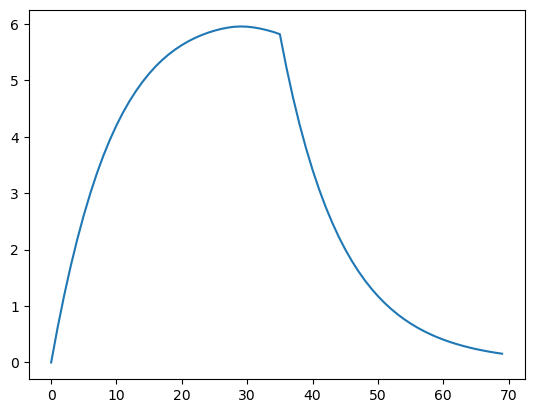

In [23]:
plt.plot(np.arange(par.T),np.mean(model.sim.k[:], axis=0))


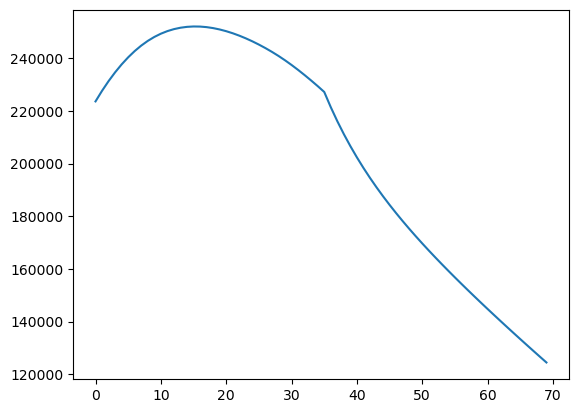

In [24]:
plt.plot(np.arange(par.T),np.mean(model.sim.w[:], axis=0))


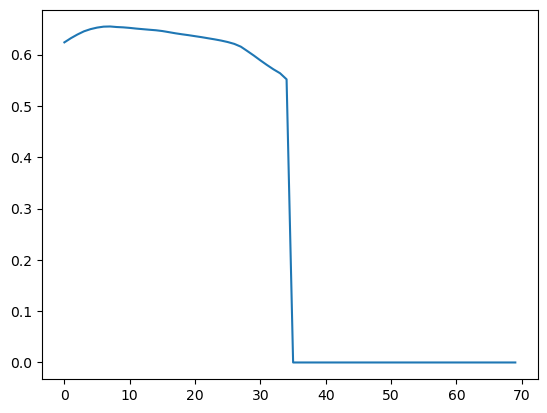

In [7]:
plt.plot(np.arange(par.T),np.mean(model.sim.h[:], axis=0))


In [8]:
model.sim.a

array([[135000.        , 119320.83225498, 107222.93728488,
         98483.7189021 ,  92858.89685605,  89618.74750609,
         88163.21505826,  88052.03266926,  88644.70253726,
         89280.87427705,  90130.09058576,  91079.80241269,
         92066.35323452,  93134.44595941,  94369.88809317,
         95792.06221315,  97157.86128061,  98248.05051077,
         98955.10971184,  99579.07420919, 100128.13877741,
        100607.62936372, 101021.97152725, 101368.88169495,
        101667.61609223, 101908.9442337 , 101916.43018673,
        101409.69800758,  99606.47232166,  95027.28065802,
         87602.03280038,  77117.40135642,  63749.99543299,
         47681.31733805,  29120.09851674,   3779.24891937,
         30280.07257849,  82145.92253649, 140918.02449672,
        205752.89270508, 276639.71951458, 353770.33079871,
        436056.70509331, 523582.17157696, 613481.78901026,
        706318.56704403, 625049.28420485, 547121.2104108 ,
        473237.2491541 , 403952.8462568 , 339738.3620768

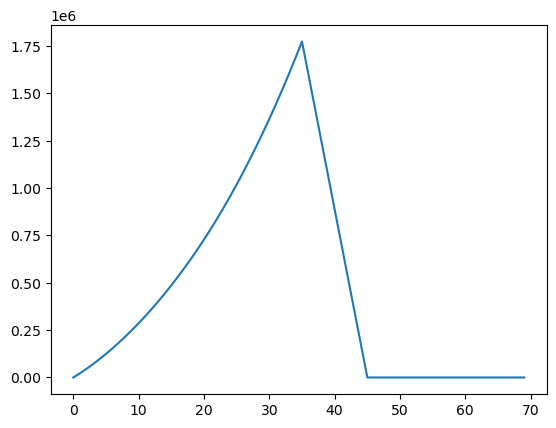

In [9]:
plt.plot(np.arange(par.T),np.mean(model.sim.s[:], axis=0))


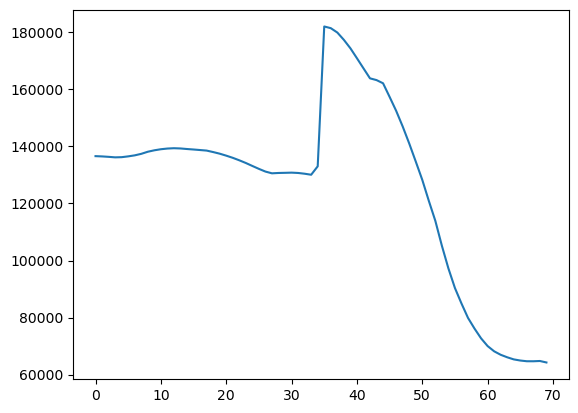

In [ ]:
plt.plot(np.arange(par.T),np.mean(model.sim.c[:], axis=0))


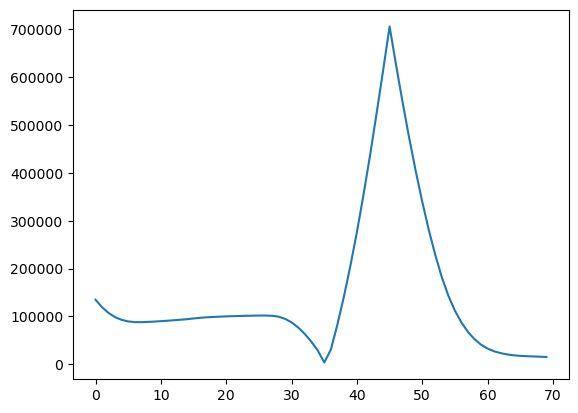

In [26]:
plt.plot(np.arange(par.T),np.mean(model.sim.a[:], axis=0))

In [27]:
np.min(model.sim.a[:])

3779.248919371617

In [11]:
(model.par.chi[-1]+model.par.a_bar)*(1/(1+(par.mu**(1/par.sigma))))

51847.932179365445

In [12]:
np.min(model.sol.a[:, :, :, :])

269.56600742009687

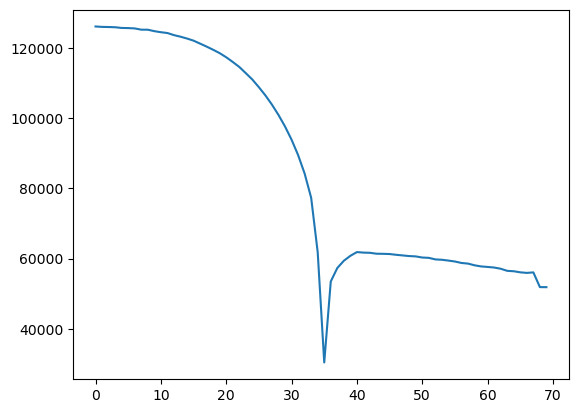

In [13]:
plt.plot(sol.c[:, 0, 0, 0])

[]

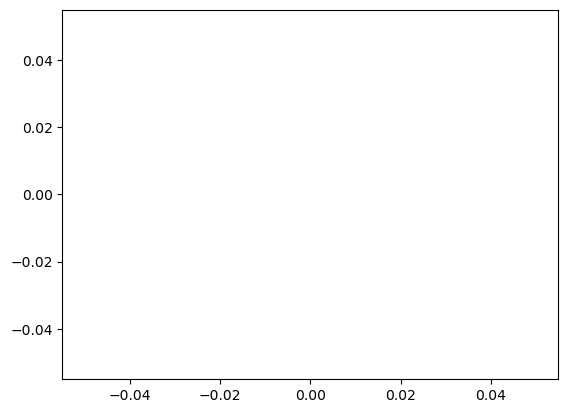

In [14]:
plt.plot()

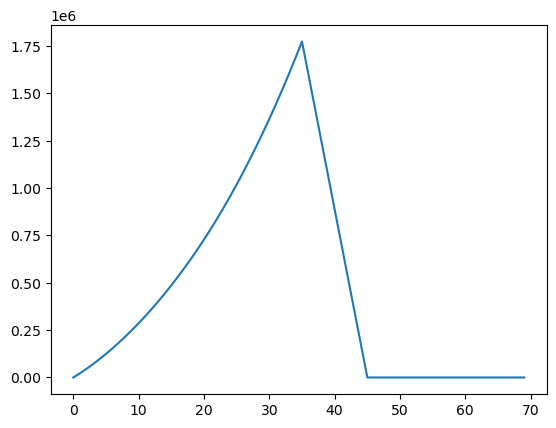

In [15]:
plt.plot(np.arange(par.T),np.mean(model.sim.s[:], axis=0))


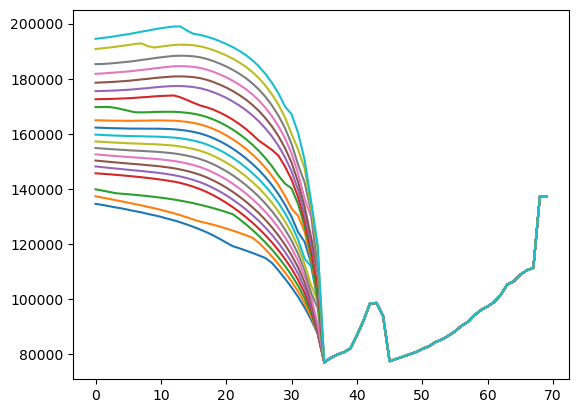

In [16]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.c[:, 1, 1, i])


In [17]:
sol.V

array([[[[-99.69300264, -99.55509936, -99.41645208, ..., -96.9576292 ,
          -96.76197078, -96.56178294],
         [-99.42490512, -99.28834853, -99.15103691, ..., -96.7085527 ,
          -96.51345592, -96.3137471 ],
         [-99.16982567, -99.03388163, -98.89716624, ..., -96.46114208,
          -96.26622592, -96.06666515],
         ...,
         [-95.46081289, -95.32522849, -95.18886902, ..., -92.75868217,
          -92.56398543, -92.36461308],
         [-95.21374779, -95.07816848, -94.94181483, ..., -92.51186002,
          -92.31717493, -92.11781287],
         [-94.96668269, -94.83110846, -94.69476064, ..., -92.26503788,
          -92.07036443, -91.87101266]],

        [[-99.45269204, -99.3208147 , -99.18728603, ..., -96.78874207,
          -96.59697528, -96.40071029],
         [-99.18333341, -99.05287174, -98.92075007, ..., -96.5395367 ,
          -96.34835561, -96.15260192],
         [-98.92763727, -98.79782523, -98.66633842, ..., -96.29207997,
          -96.10109017, -95.90549

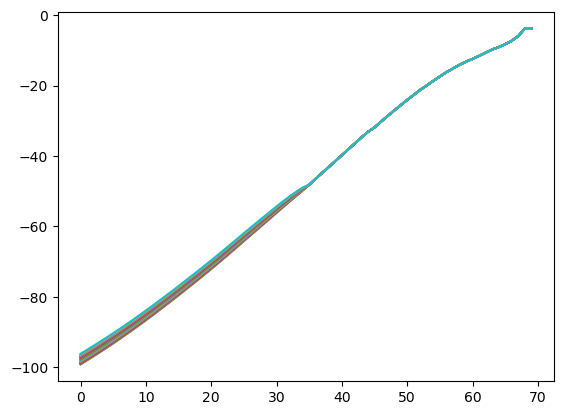

In [18]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.V[:, 1, 1, i])


In [19]:
sol.V[:, 4, 4, :]

array([[-97.74557381, -97.62936984, -97.51045272, ..., -95.30297057,
        -95.12337305, -94.93948227],
       [-96.59214435, -96.47670919, -96.35862466, ..., -94.17518208,
        -93.9980876 , -93.81690563],
       [-95.43462232, -95.31997781, -95.20274966, ..., -93.04384605,
        -92.86929646, -92.69086457],
       ...,
       [ -5.37451006,  -5.37451006,  -5.37451006, ...,  -5.37451006,
         -5.37451006,  -5.37451006],
       [ -3.39433906,  -3.39433906,  -3.39433906, ...,  -3.39433906,
         -3.39433906,  -3.39433906],
       [ -3.39433915,  -3.39433915,  -3.39433915, ...,  -3.39433915,
         -3.39433915,  -3.39433915]])

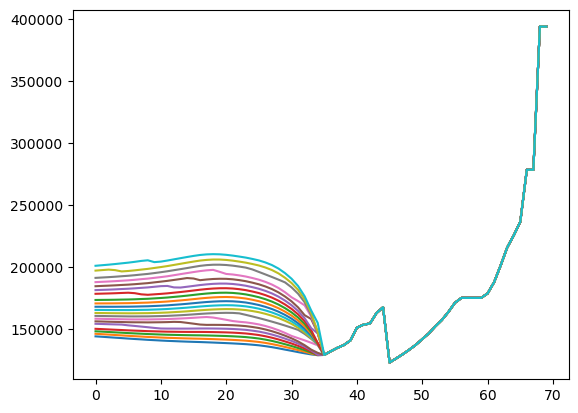

In [20]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.c[:, 4, 4, i])

In [21]:
sol.V[:-1, 4, 4, 4]-sol.V[1:, 4, 4, 4]

array([-1.14999088e+00, -1.15399016e+00, -1.18609699e+00, -1.21651653e+00,
       -1.21461102e+00, -1.26327385e+00, -1.30138744e+00, -1.28512316e+00,
       -1.35783640e+00, -1.34914217e+00, -1.37410431e+00, -1.42211517e+00,
       -1.40957480e+00, -1.43592121e+00, -1.45980897e+00, -1.48278990e+00,
       -1.47681535e+00, -1.48509444e+00, -1.50330738e+00, -1.53409665e+00,
       -1.55143702e+00, -1.56665443e+00, -1.60101883e+00, -1.58738629e+00,
       -1.62603213e+00, -1.59128821e+00, -1.60217917e+00, -1.59374594e+00,
       -1.59096692e+00, -1.62866591e+00, -1.59901466e+00, -1.59309735e+00,
       -1.56380271e+00, -1.58147854e+00, -1.58898571e+00, -1.67047909e+00,
       -1.64818956e+00, -1.60054516e+00, -1.66379488e+00, -1.63835975e+00,
       -1.67374934e+00, -1.63286775e+00, -1.65931302e+00, -1.55677374e+00,
       -7.00469162e-01, -1.63442705e+00, -1.56978861e+00, -1.52892346e+00,
       -1.49021810e+00, -1.50702412e+00, -1.39278299e+00, -1.42111994e+00,
       -1.23656445e+00, -

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\B465929\AppData\Local\Temp\ipykernel_19036\2554536382.py:22: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')
C:\Users\B465929\AppData\Local\Temp\ipykernel_19036\2554536382.py:28: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')


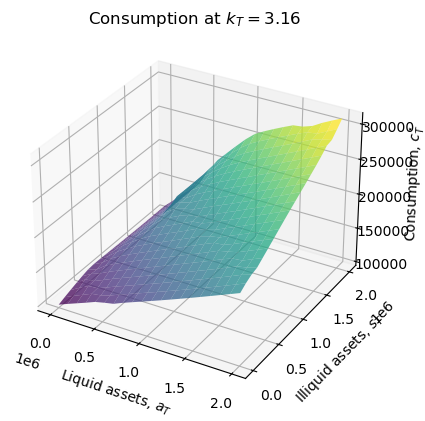

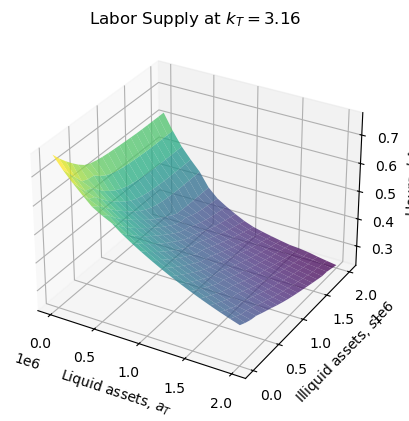

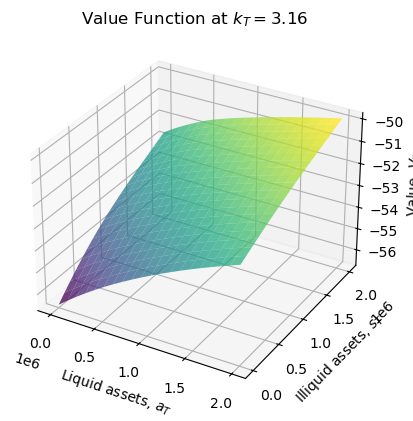

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Choose a fixed k index (e.g., middle of the k_grid)
k_idx = 2
k_fixed = par.k_grid[k_idx]  

# Extract the meshgrid for plotting
a_mesh, s_mesh = np.meshgrid(par.a_grid, par.s_grid, indexing='ij')

# Extract solutions at time t and fixed k
t = 30
c_plot = sol.c[t, :, :, k_idx]  # Fix k_idx
h_plot = sol.h[t, :, :, k_idx]
V_plot = sol.V[t, :, :, k_idx]

# Plot consumption
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, c_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')

# Plot labor supply
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, h_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')

# Plot value function
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, V_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Value, $V_{T}$', title=f'Value Function at $k_T = {k_fixed:.2f}$')

plt.show()
